# Installing Packagages

In [12]:
!pip install qiskit --quiet

In [13]:
!pip install pylatexenc --quiet

In [14]:
!pip install qiskit-ibm-runtime --quiet

In [15]:
!pip install qiskit-algorithms --quiet

# Importing Packages

In [16]:
from qiskit.quantum_info import SparsePauliOp
from math import sin, cos, pi
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms import TrotterQRTE
from qiskit.primitives import Estimator 
import scipy as sc
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter
from qiskit.synthesis import SuzukiTrotter
from qiskit.synthesis import SuzukiTrotter
from matplotlib import cm

# IBM API Token

In [17]:
IBM_API = '775d892deb7ca683746f77d5d3e054d71d735c7a87a8111da3e3395ef933c1c9f2f14d7ce90208334fd8ee792466cbbc4398d386ecfa0d923a75114832a16678'

# Defining Parameters of Hamiltonian

In [18]:
params = {
    'L': 3,
    'J': 1,
    'alpha': 1,
}

# Hamiltonian Definition

In [19]:
def get_hamiltonian(params, **kwargs):
    '''
    Returns a general XY Hamiltonian.
    '''
    ## Extract parameters
    L, alpha, J = params['L'], params['alpha'], params['J']
    
    ### Define the XX and YY tuples with corrected list comprehension
    ## List of Hamiltonian terms as 3-tuples containing
    ## (1) the Pauli string,
    ## (2) the qubit indices corresponding to the Pauli string,
    ## (3) the coefficient.
    XX_tuples = [("XX", [i, j], -J / np.power(np.abs(i - j), alpha)) for i in range(L - 1) for j in range(i + 1, L)]
    YY_tuples = [("YY", [i, j], -J / np.power(np.abs(i - j), alpha)) for i in range(L - 1) for j in range(i + 1, L)]
    
    # Combine the tuples to create the Hamiltonian
    hamiltonian = SparsePauliOp.from_sparse_list([*XX_tuples, *YY_tuples], num_qubits=L)
    return hamiltonian.simplify()

# params = {'L': 3, 'alpha': 1.5, 'J': 1.0}
# hamiltonian = get_hamiltonian(params)

# n-Qubit GHZ Initial State

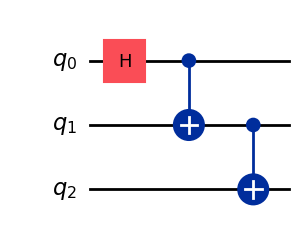

<IPython.core.display.Latex object>

In [24]:
def get_qc_for_n_qubit_GHZ_state(params, **kwargs):
    """This function will create a qiskit.QuantumCircuit (qc) for an n-qubit GHZ state.
 
    Args:
        params - only requires 'L' parameter to construct Q.circuit and entangled state.
 
    Returns:
        QuantumCircuit: Quantum circuit that generate the n-qubit GHZ state, assuming all qubits start in the 0 state
        Entangled n-qubit GHZ state
    """
    n = params['L']
    initial_state = '0' * n
    sv1 = Statevector.from_label(initial_state)
    if isinstance(n, int) and n >= 2:
        qc = QuantumCircuit(n)
        qc.h(0)
        for i in range(n-1):
            qc.cx(i, i+1)
    else:
        raise Exception("n is not a valid input")
    new_sv1 = sv1.evolve(qc)
    return qc, new_sv1

params['L'] = 3
GHZ_qc, new_sv1 = get_qc_for_n_qubit_GHZ_state(params)
display(GHZ_qc.draw('mpl'))
display(new_sv1.draw('latex'))

# Time Evolution of the state

In [25]:
final_time = 1.6

# First spin up, second spin down
# (remember that the labels are interpreted from right to left)
initial_state = Statevector.from_label("000")

H = get_hamiltonian(params)
problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time)

In [26]:
trotter = TrotterQRTE()
result = trotter.evolve(problem)

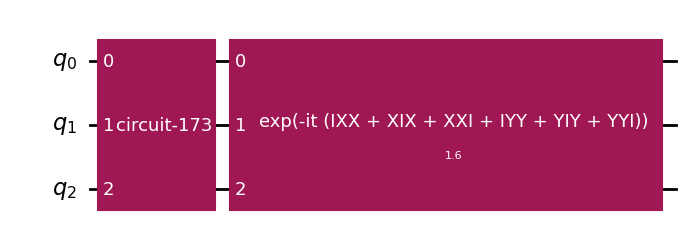

In [27]:
result.evolved_state.draw("mpl")

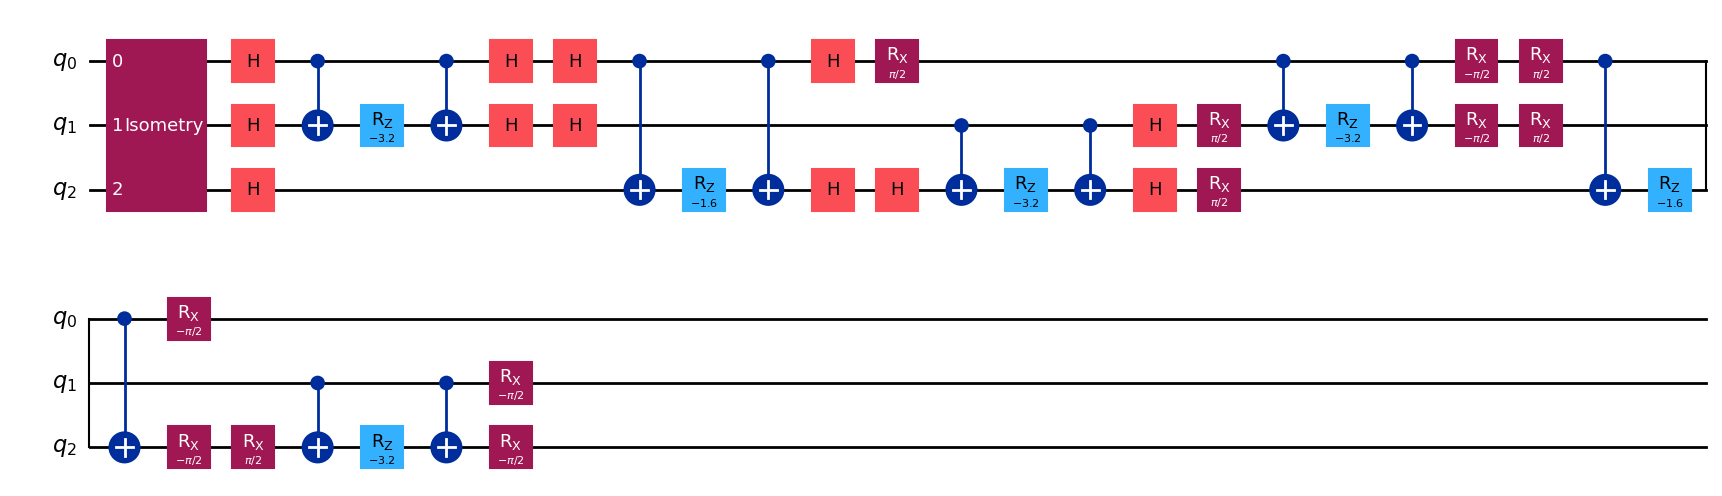

In [28]:
result.evolved_state.decompose(reps=2).decompose("disentangler_dg").decompose(
    "multiplex1_reverse_dg"
).draw("mpl")

In [29]:
statevector = Statevector(result.evolved_state)
print(statevector)

Statevector([-9.98344525e-01+0.00170304j,  0.00000000e+00+0.j        ,
              0.00000000e+00+0.j        , -2.91248772e-02+0.02833628j,
             -0.00000000e+00+0.j        ,  4.97492792e-05-0.00170304j,
             -2.91248772e-02+0.02833628j,  0.00000000e+00+0.j        ],
            dims=(2, 2, 2))


In [30]:
num_timesteps = 60
trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())

/tmp/ipykernel_3464/2961244063.py:2: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())


In [31]:
L = 3
X_op = SparsePauliOp.from_sparse_list(
    [("Z", [i], 1.0) for i in range(0, L)], num_qubits=L
)
correlation_op = SparsePauliOp.from_sparse_list(
    [("ZZ", [i, j], 1.0) for i in range(0, L - 1) for j in range(i+1, L)], num_qubits=L
)

In [35]:
Pseq = ['III', 'IZZ', 'IIZ', 'IZI']
XX_tuples = [(P[i]+"X"+P[i]+P[j]+"X"+P[j], [i, i, i, j, j,  j], -params['J'] / np.power(np.abs(i - j), params['alpha'])) for P in Pseq for i in range(L - 1) for j in range(i + 1, L)]
YY_tuples = [(P[i]+"Y"+P[i]+P[j]+"Y"+P[j], [i, i, i, j, j,  j], -params['J'] / np.power(np.abs(i - j), params['alpha'])) for P in Pseq for i in range(L - 1) for j in range(i + 1, L)]
# print(XX_tuples)
# Combine the tuples to create the Hamiltonian
hamiltonian = SparsePauliOp.from_sparse_list([*XX_tuples, *YY_tuples], num_qubits=L)

QiskitError: 'Input indices are duplicated.'

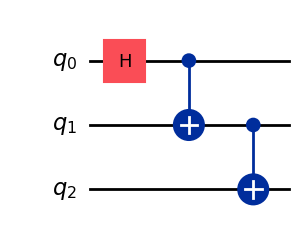

<IPython.core.display.Latex object>

In [150]:
final_time = 40.0
# initial_state = Statevector.from_label("10")
# sv1 = Statevector.from_label('00') # start with |00>

# mycircuit1 = QuantumCircuit(2)
# mycircuit1.h(0)
# mycircuit1.cx(0,1)

# mycircuit1.x(0) # apply x gate after CNOT

# new_sv1 = sv1.evolve(mycircuit1)
# display(mycircuit1.draw('mpl'))
# display(new_sv1.draw('latex'))
# initial_state = new_sv1

sv1 = Statevector.from_label('000') 

GHZ_qc = QuantumCircuit(3)
GHZ_qc.h(0)
[GHZ_qc.cx(i,i+1) for i in range(2)]

new_sv1 = sv1.evolve(GHZ_qc)
display(GHZ_qc.draw('mpl'))
display(new_sv1.draw('latex'))

initial_state = new_sv1
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[X_op, correlation_op],
)

In [151]:
result = trotter.evolve(problem)

In [152]:
observables = np.array(np.array(result.observables)[:, :, 0])
observables.shape

(61, 2)

Text(0.5, 0.98, 'Observable evolution')

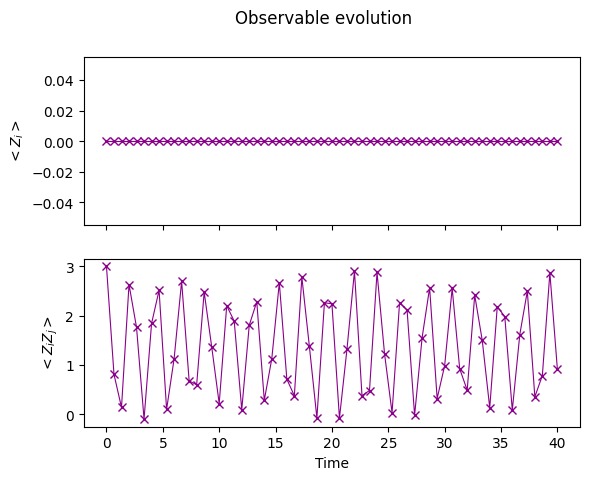

In [153]:
fig, axes = plt.subplots(2, sharex=True)
times = np.linspace(0, final_time, num_timesteps + 1)  # includes initial state
axes[0].plot(
    times, observables[:, 0], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[1].plot(
    times, np.round(observables[:, 1].astype(float), decimals = 3), label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
# axes[2].plot(
#     times, observables[:, 2], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
# )
axes[0].set_ylabel(f"$<Z_i>$")
axes[1].set_ylabel(f"$<Z_iZ_j>$")
# axes[2].set_ylabel("Mean spin correlation")
axes[1].set_xlabel("Time")
fig.suptitle("Observable evolution")

In [154]:
np.round(observables[:, 0].astype(float), decimals = 3)

array([ 0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,
       -0., -0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0.,
        0., -0.,  0.,  0.,  0., -0., -0.,  0.,  0.])